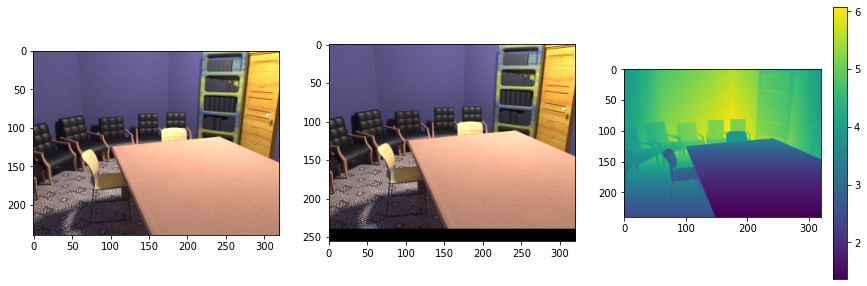

In [69]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')
from dataset_openroomsV4_utils import loadBinary
import matplotlib.pyplot as plt
import cv2
import torch

pad_to = [256, 320]

png_path_ROOT = Path('/data/ruizhu/OR-pngs')
RAW_ROOT = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation')

val_list_file = '/home/ruizhu/Documents/Projects/semanticInverse/train/data/openrooms/list_OR_V4full/list/val.txt'
list_read = open(val_list_file).readlines()
scene_list = []
frame_info_list = []
for line in list_read:
    line = line.strip()
    line_split = line.split(' ')
    meta_split = line_split[2].split('/')[0]
    scene_name = line_split[2].split('/')[1]
    frame_id = int(line_split[1])
    frame_info_list.append([meta_split, scene_name, frame_id])

frame_id_pick = 1
meta_split, scene_name, frame_id = frame_info_list[frame_id_pick]

im_width, im_height = 320, 240

png_path = png_path_ROOT / meta_split / scene_name / ('im_%d.png'%frame_id)
depth_path = RAW_ROOT / (meta_split.replace('DiffMat', '').replace('DiffLight', '')) / scene_name / ('imdepth_%d.dat'%frame_id)

im = plt.imread(png_path)
im = cv2.resize(im, (im_width, im_height), interpolation=cv2.INTER_AREA )

depth = loadBinary(depth_path, if_resize=True, im_width=im_width, im_height=im_height)

im_padded = np.zeros((pad_to[0], pad_to[1], 3), dtype=np.float32)
im_padded[:240, :, :] = im
im_tensor = torch.from_numpy(im_padded.transpose(2, 0, 1)).unsqueeze(0).cuda()
depth_tensor = torch.from_numpy(depth).unsqueeze(0).cuda()

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(im)
plt.subplot(132)
plt.imshow(im_padded)
plt.subplot(133)
plt.imshow(depth)
plt.colorbar()
plt.show()


# SSN 2D from RGB feats/matseg feats

In [180]:
import torch
import numpy as np

task_name = '20210719-233411--eval_matseg_resume20201120-223702'
save_file_ROOT = Path('/newfoundland2/ruizhu/semanticInverse_resources/Summary_vis_20210504/')
embedding_file_name = save_file_ROOT / task_name / ('matseg_pred_embedding_tid306000_idx%d.npy'%frame_id_pick)

embedding_ori = np.load(embedding_file_name)
embedding = np.zeros((4, pad_to[0], pad_to[1]), dtype=np.float32)
embedding[:, :240, :] = embedding_ori
embedding_tensor = torch.from_numpy(embedding).cuda().unsqueeze(0)

mask = np.zeros((pad_to[0], pad_to[1]), dtype=np.float32)
mask[:240, :] = 1.
mask_tensor = torch.from_numpy(mask).cuda().unsqueeze(0)


from models_def.model_nvidia.AppGMM_adaptive import SSNFeatsTransformAdaptive
from skimage.segmentation import mark_boundaries

# spixel_nums=(6, 4)
# spixel_nums=(8, 6)
# spixel_nums=(12, 8)
spixel_nums=(10, 8)
# spixel_nums=(20, 16) # patch size of 16

# spixel_nums=(24, 16)
# spixel_nums=(16, 12)
ssn_op = SSNFeatsTransformAdaptive(None, (spixel_nums[1], spixel_nums[0]), if_dense=False)

# Choose between RGB feats, matseg feats and deconv feats
# ssn_output = ssn_op(im_tensor)
import time
tic = time.time()
# ssn_output = ssn_op(feats_in=embedding_tensor, tensor_to_transform=im_tensor, index_add=True)
ssn_output = ssn_op(feats_in=embedding_tensor, tensor_to_transform=im_tensor, mask=mask_tensor, index_add=False)
print(time.time() - tic)

abs_affinity, feats_recon = ssn_output['abs_affinity'], ssn_output['tensor_recon']
abs_affinity_np = abs_affinity.squeeze().detach().cpu().numpy()
feats_recon_np = feats_recon.squeeze().detach().cpu().numpy()
print(abs_affinity_np.shape, feats_recon_np.shape) # (12, 240, 320) (3, 240, 320)

im_recon = feats_recon_np.transpose(1, 2, 0)

0.028235197067260742
(80, 256, 320) (3, 256, 320)


In [163]:
idx_mask.shape

()

In [165]:
index_abs2rel.shape

(9, 256, 320)

In [164]:
index_abs2rel==idx].shape

(5120,)

In [172]:
ssn_output['index_abs2rel'].shape

torch.Size([9, 256, 320])

torch.Size([3, 5120])


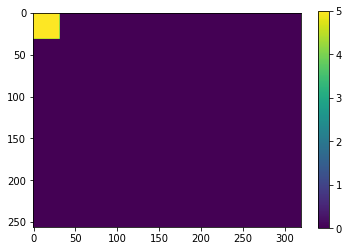

torch.Size([3, 9216])


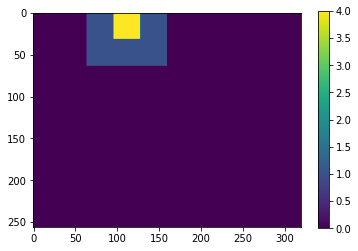

torch.Size([3, 9216])


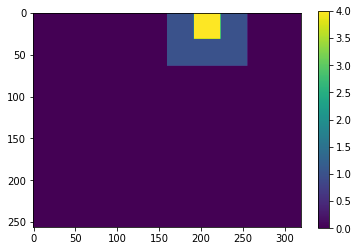

torch.Size([3, 10240])


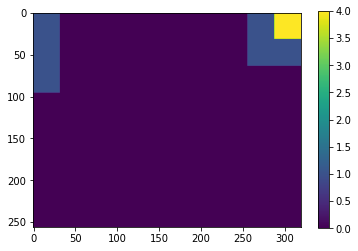

torch.Size([3, 9216])


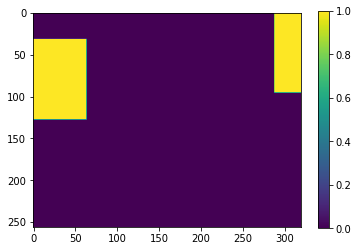

torch.Size([3, 9216])


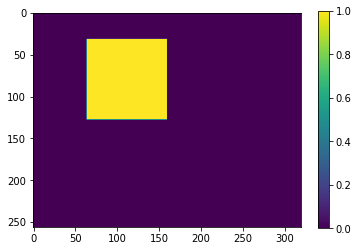

torch.Size([3, 9216])


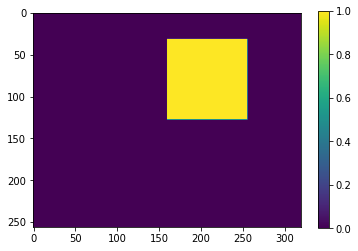

torch.Size([3, 9216])


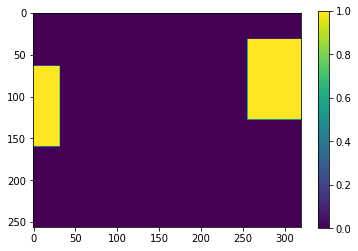

torch.Size([3, 9216])


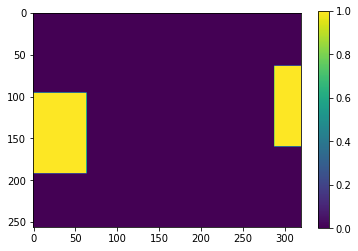

torch.Size([3, 9216])


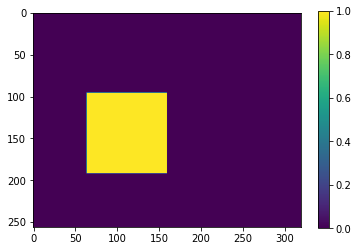

torch.Size([3, 9216])


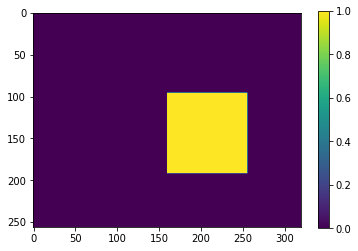

torch.Size([3, 9216])


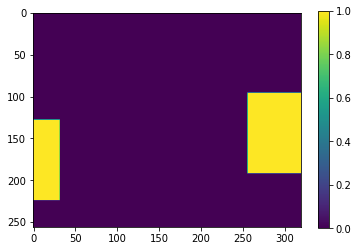

torch.Size([3, 9216])


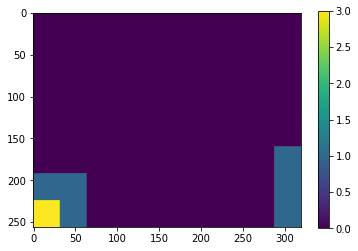

torch.Size([3, 9216])


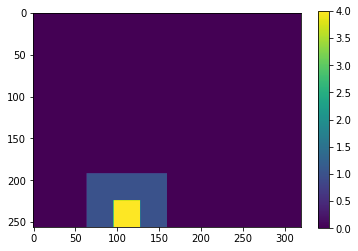

torch.Size([3, 9216])


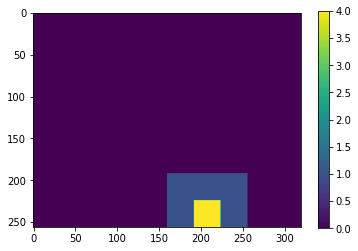

torch.Size([3, 9216])


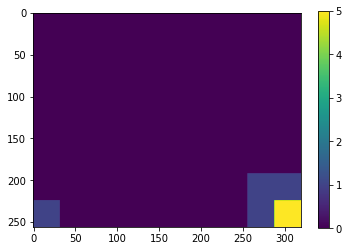

In [175]:
index_abs2rel_np = ssn_output['index_abs2rel'].cpu().detach().numpy()
im_feat_fake = torch.ones((3, 256, 320)).cuda()
im_feat_fake = im_feat_fake.unsqueeze(1).repeat(1, 9, 1, 1)
for idx_0 in [0, spixel_nums[1]//3, spixel_nums[1]//3*2, spixel_nums[1]-1]:
    for idx_1 in [0, spixel_nums[0]//3, spixel_nums[0]//3*2, spixel_nums[0]-1]:
        idx = idx_0 * spixel_nums[0] + idx_1
        idx_mask = (index_abs2rel_np==idx).sum(0)
        im_feat_fake_gather = im_feat_fake[:, ssn_output['index_abs2rel']==idx]
        print(im_feat_fake_gather.shape)
        plt.figure()
        plt.imshow(idx_mask)
        plt.colorbar()
        plt.show()

0 0 0
4096


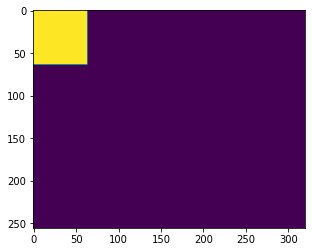

0 3 3
6144


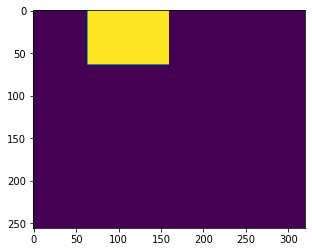

0 6 6
6144


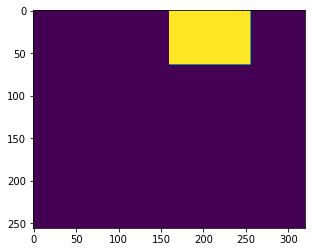

0 9 9
4096


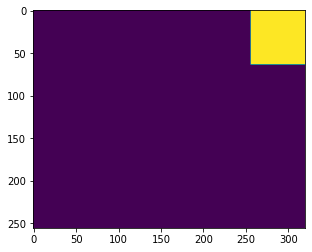

2 0 20
6144


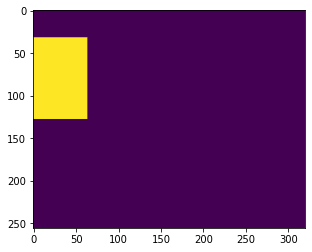

2 3 23
9216


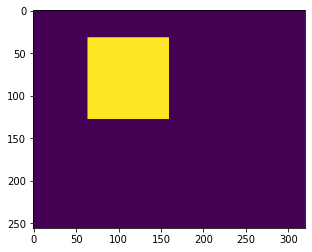

2 6 26
9216


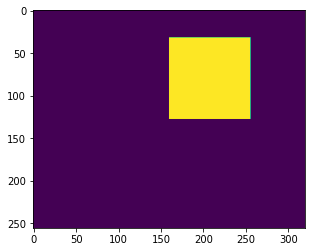

2 9 29
6144


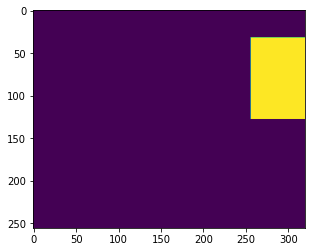

4 0 40
6144


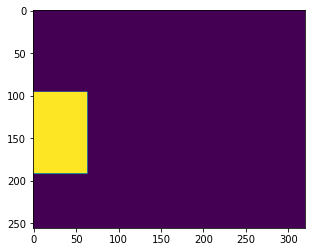

4 3 43
9216


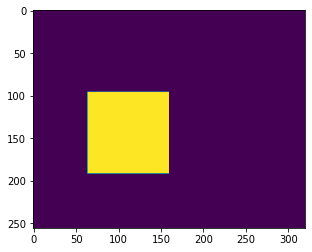

4 6 46
9216


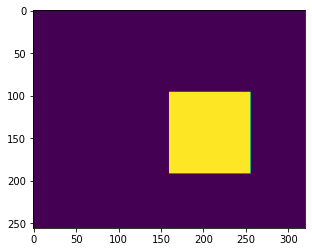

4 9 49
6144


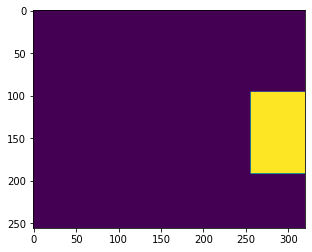

7 0 70
3072


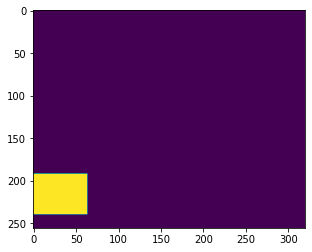

7 3 73
4608


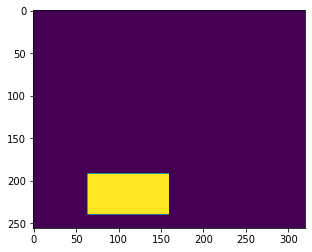

7 6 76
4608


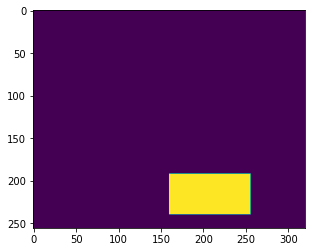

7 9 79
3072


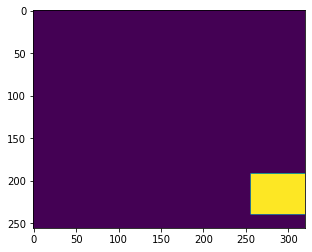

In [182]:
# abs_affinity_normalized_by_pixels = ssn_output['abs_affinity_normalized_by_pixels'][0].cpu().numpy()
abs_affinity = ssn_output['abs_affinity'][0].cpu().numpy()

for idx_0 in [0, spixel_nums[1]//3, spixel_nums[1]//3*2, spixel_nums[1]-1]:
    for idx_1 in [0, spixel_nums[0]//3, spixel_nums[0]//3*2, spixel_nums[0]-1]:
# for idx_0 in [0, 1]:
#     for idx_1 in [0, 1]:
        idx = idx_0 * spixel_nums[0] + idx_1
        print(idx_0, idx_1, idx)
        plt.figure()
        a = abs_affinity_normalized_by_pixels[idx]
        print(np.sum(a!=0))
#         a = abs_affinity[idx]
#         plt.imshow(a * 256*320 / 3)
        plt.imshow(a>0.)
        plt.show()
        
        

(80, 256, 320) (3, 256, 320)
(256, 320)


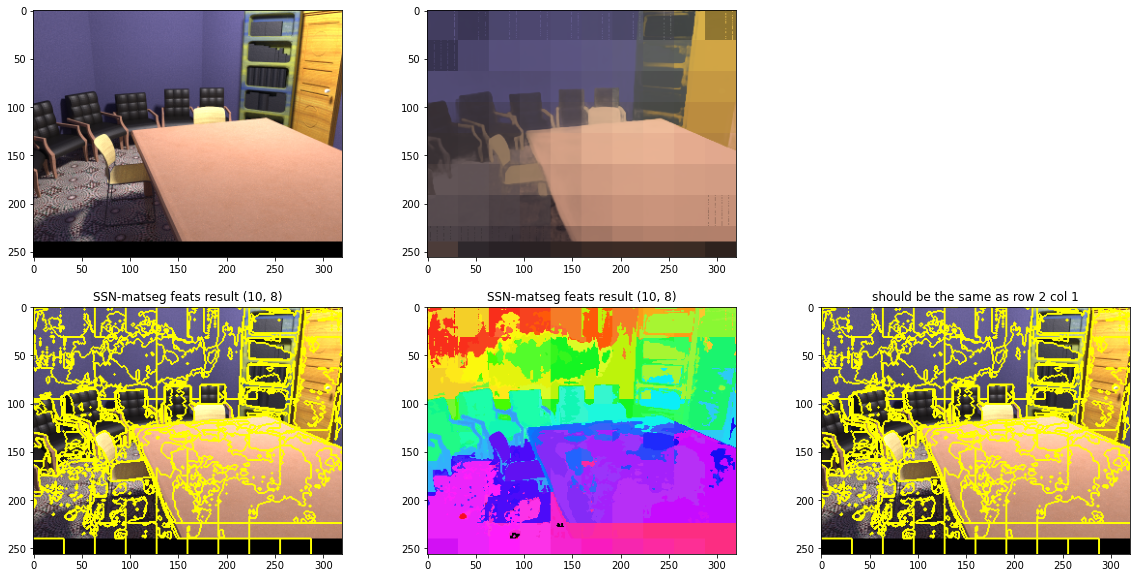

In [81]:
abs_affinity, feats_recon = ssn_output['abs_affinity'], ssn_output['tensor_recon']
abs_affinity_np = abs_affinity.squeeze().detach().cpu().numpy()
feats_recon_np = feats_recon.squeeze().detach().cpu().numpy()
print(abs_affinity_np.shape, feats_recon_np.shape) # (12, 240, 320) (3, 240, 320)

affinity_matrix_label = np.argmax(abs_affinity_np, 1)

im_recon = feats_recon_np.transpose(1, 2, 0)

affinity_matrix_label = torch.argmax(abs_affinity, 1).squeeze().detach().cpu().numpy()
print(affinity_matrix_label.shape)
im_ssn_result = mark_boundaries(im_padded, affinity_matrix_label)

import models_def.model_nvidia.utils.misc as utils_misc_ssn
img_boundary = utils_misc_ssn.mark_gamma_boundary(
    img_rgb= im_tensor[0].squeeze().permute(1,2,0), 
    gamma = abs_affinity[0].permute(1,2,0)) 

from utils.utils_vis import vis_index_map
affinity_matrix_label_vis = vis_index_map(affinity_matrix_label)

plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.imshow(im_padded)
plt.subplot(232)
plt.imshow(im_recon)
ax = plt.subplot(234)
plt.imshow(im_ssn_result)
ax.set_title('SSN-matseg feats result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))
ax = plt.subplot(235)
plt.imshow(affinity_matrix_label_vis)
ax.set_title('SSN-matseg feats result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))
ax = plt.subplot(236)
plt.imshow(img_boundary)
ax.set_title('should be the same as row 2 col 1')
plt.show()

In [82]:
abs_affinity_np.shape

(80, 256, 320)

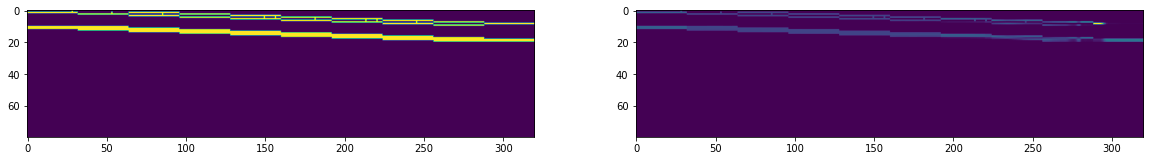

In [83]:
Q_row = abs_affinity_np[:, 0, :]
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.imshow(Q_row>0.)
plt.subplot(122)
plt.imshow(Q_row)
plt.show()

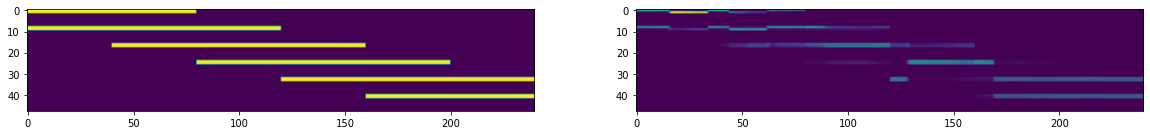

In [21]:
Q_col = abs_affinity_np[:, :, 1]
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.imshow(Q_col>0.)
plt.subplot(122)
plt.imshow(Q_col)
plt.show()

In [140]:
embedding.shape

(4, 240, 320)

### vis embedding vis T-SNE

In [ ]:
import sklearn
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(embedding.transpose(1, 2, 0).reshape(-1, 4))

In [ ]:
X_embedded.shape

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(im)
plt.subplot(222)
plt.imshow(im_recon)
ax = plt.subplot(223)
plt.imshow(im_ssn_result)
ax.set_title('SSN-matseg feats result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))
ax = plt.subplot(224)
plt.imshow(affinity_matrix_label_vis)
ax.set_title('SSN-matseg feats result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))

plt.show()

# SSN 3D

In [4]:
import models_def.model_nvidia.AppGMM_singleFrame as AppGMM
from utils.utils_scannet import convert_IntM_from_OR, CamIntrinsic_to_cuda

spixel_nums=(16, 12)
# spixel_nums=(6, 4)

MODEL_GMM = AppGMM.AppGMM(None, spixel_nums=spixel_nums)

cam_K_320x240 = np.array([[288.9354, 0., 160.], [0., 288.9354, 120.], [0., 0.,1.]]) # for 240x320 OR ONLY
cam_intrinsic = convert_IntM_from_OR(cam_K_320x240)
CamIntrinsic_to_cuda(cam_intrinsic, device='cuda') 
MODEL_GMM.set_camintrinsic(cam_intrinsic)

input_dict_GMM = {'imgs_ref': im_tensor, 'dmaps_ref': depth_tensor}
return_dict_GMM = MODEL_GMM.forward(input_dict_GMM, batch_idx=0, return_dict=True, if_recon_depth=True)
abs_affinity = return_dict_GMM['gamma_update']

print(return_dict_GMM.keys())

im_resampled_ssn3d = MODEL_GMM.appearance_recon(return_dict_GMM['gamma_update'], input_dict_GMM['imgs_ref'], scale_feat_map=1)
im_resampled_ssn3d.shape


dict_keys(['gmm_params_update', 'gamma_update', 'dmap_update_resample', 'sigma_update_resample'])


torch.Size([1, 3, 240, 320])

(240, 320)


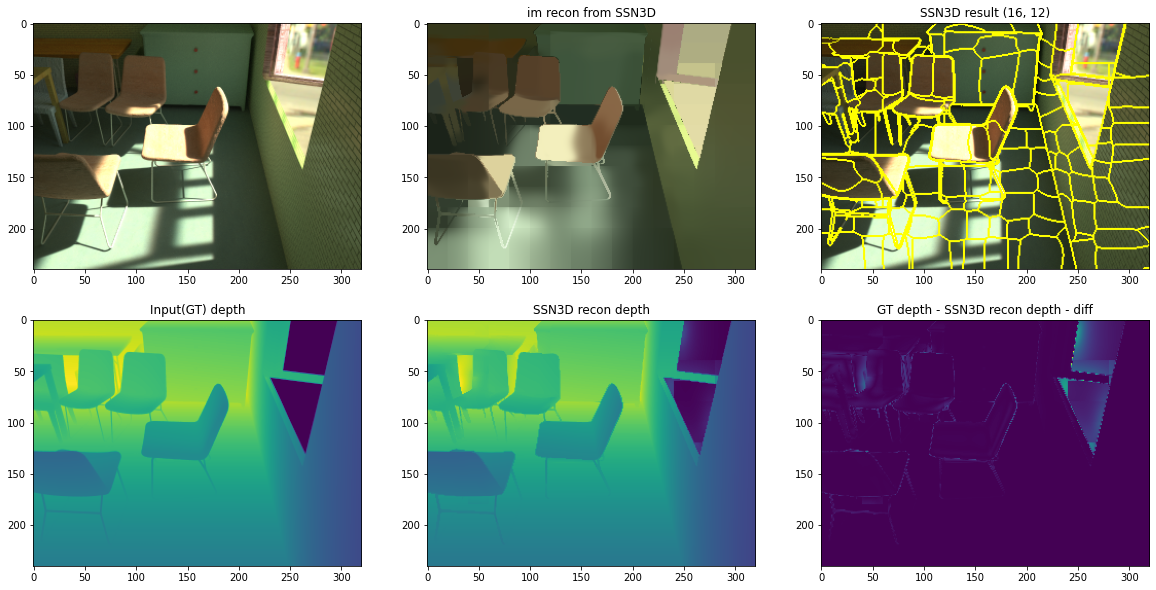

In [5]:
depth_recon = return_dict_GMM['dmap_update_resample'].squeeze().detach().cpu().numpy()
affinity_matrix_label = torch.argmax(abs_affinity, 1).squeeze().detach().cpu().numpy()
print(affinity_matrix_label.shape)
im_ssn3d_result = mark_boundaries(im, affinity_matrix_label)
im_resampled_ssn3d_np = im_resampled_ssn3d.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.imshow(im)
ax = plt.subplot(232)
plt.imshow(im_resampled_ssn3d_np)
ax.set_title('im recon from SSN3D')
ax = plt.subplot(233)
plt.imshow(im_ssn3d_result)
ax.set_title('SSN3D result (%d, %d)'%(spixel_nums[0], spixel_nums[1]))

ax = plt.subplot(234)
plt.imshow(depth)
ax.set_title('Input(GT) depth')
ax = plt.subplot(235)
plt.imshow(depth_recon)
ax.set_title('SSN3D recon depth')
ax = plt.subplot(236)
plt.imshow(np.abs(depth_recon-depth))
ax.set_title('GT depth - SSN3D recon depth - diff')
plt.show()